# Easy Visa

## Problem Statement

**Context**

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

**Objective**:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

Facilitate the process of visa approvals.
Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

**Data Description**

The data contains the different attributes of employee and the employer. The detailed data dictionary is given below.

- **case_id**: ID of each visa application
- **continent**: Information of continent the employee
- **education_of_employee**: Information of education of the employee
- **has_job_experience**: Does the employee has any job experience? Y= Yes; N = No
- **requires_job_training**: Does the employee require any job training? Y = Yes; N = No
- **no_of_employees**: Number of employees in the employer's company
- **yr_of_estab**: Year in which the employer's company was established
- **region_of_employment**: Information of foreign worker's intended region of employment in the US.
- **full_time_position**: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
- **unit_of_wage**: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
- **prevailing_wage**: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
- **case_status**: Flag indicating if the Visa was certified or denied

**BirdEye** 👀

It consists of visa application records with features related to the employee (e.g., education, experience), the employer (e.g., company size, establishment year), job details (e.g., wage, employment region), and the final case status (certified or denied)

*Goal (Brief)*

This problem aims to predict the **approval** or **denial** of a U.S. work visa application based on various factors related to the employee and employer. Given the increasing number of visa applications, manually reviewing each case is becoming inefficient. Hence need a machine learning (ML) model that can help automate and streamline the decision-making process.

This is a classification problem, where the target variable (case_status) has two possible outcomes:

- Certified (Visa Approved)
- Denied (Visa Rejected)


**Key Questions that can be answered** 🎯

1. What factors influence visa approval the most?
2. Do certain types of applicants have a better chance of approval?
3. Does salary or wage type affect visa approval?
4. Do bigger or older companies have an advantage?

## Data background and Contents


The dataset contains 11 columns, including:  

- **Employee details**: Continent, Education, Job Experience, Job Training  
- **Employer details**: Number of Employees, Year of Establishment  
- **Job attributes**: Region of Employment, Prevailing Wage, Wage Unit, Full-time Position  
- **Target variable**: Case Status (Certified or Denied)  

The model will analyze historical visa application data and learn patterns that distinguish approved cases from rejected ones.

**Key Features (Predictors)**  
1. **Employee attributes:**  
   - Education level  
   - Job experience  
   - Job training requirements  

2. **Employer attributes:**  
   - Number of employees  
   - Year of establishment  

3. **Job & wage details:**  
   - Region of employment  
   - Prevailing wage & wage unit (Hourly, Weekly, etc.)  
   - Full-time or part-time position  

### Preparation

In [1]:
# verify
import sys
print(sys.executable, sys.version)

/Users/nipunshah/anaconda3/bin/python 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


In [110]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate as tb
# Import required library
from statsmodels.graphics.mosaicplot import mosaic

# Suppress warnings
import warnings
warnings.filterwarnings('ignore') # Ignores all warnings (optional)

In [111]:
# Global options and themes

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Show 100 rows by default

# Seaborn theme for consistent plotting style
sns.set_theme(style="whitegrid", palette="muted", context="notebook")  # You can change it to darkgrid, ticks, etc.
plt.rcParams["figure.figsize"] = (15, 6)  # Set default figure size for plots
plt.rcParams["font.size"] = 14            # Set font size for readability

# restrict float display to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# Helpers

def tb_describe(df_col):
    """
    Helper function to display descriptive statistics in a nicely formatted table

    Parameters:
    df_col : pandas Series or DataFrame column
        The column to generate descriptive statistics for

    Returns:
    None - prints formatted table
    """
    stats = df_col.describe().to_frame().T
    print(tb.tabulate(stats, headers='keys', tablefmt='simple', floatfmt='.2f'))

In [5]:
# Primitive Utils
def snake_to_pascal(snake_str, join_with=" "):
    """Convert snake_case to PascalCase (eg my_name -> MyName)
    Args:
        snake_str (str): string to convert
        join_with (str): character to join the components, default is space
    """
    components = snake_str.split("_")
    return join_with.join(x.title() for x in components)


def format_pct(val):
    """Format a val as percentage i.e max 2 decimal value & adding % at the end"""
    return f"{val:.1f}%"

def to_percentage(value):
    """value is expected to be a normalized float value in [0, 1]"""
    return format_pct(value * 100)

def calc_iqr(series: pd.Series):
    """
    series: array of numerical values
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

In [6]:
def draw_countplot(
    df,
    colName: str,
    *,
    label=None,
    rot=0,
    order=None,
    sort=True,
    palette=None,
    showgrid=None,
):
    """
    Draw a count plot with value labels and optional features
    """
    # prep (meta) --
    xlabel = label if label else snake_to_pascal(colName)
    priority = None
    if order is not None:
        priority = order
    elif sort:
        # sort by count
        priority = df[colName].value_counts().index

    # plot (crux) --
    ax = sns.countplot(data=df, x=colName, order=priority, palette=palette)
    # display count above each bar
    ax.bar_label(ax.containers[0])

    # Calculate & mark percentages
    total = len(df[colName])
    for p in ax.patches:
        freq = p.get_height()
        percentage = to_percentage(freq / total)
        ax.annotate(
            percentage,
            (p.get_x() + p.get_width() / 2.0, freq / 2.0),
            ha="center",
            va="center",
        )

    # aesthetics --
    plt.title(f"Frequency of {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.xticks(rotation=rot)
    if showgrid:
        plt.grid(True)
    plt.show()

In [7]:
# list all files in current directory
!ls

EasyVisa.csv   minenotes      notebook.ipynb points         summary


In [8]:
# Load the dataset
df = pd.read_csv('EasyVisa.csv')
# backup of original df
df_original = df.copy()

In [9]:
# Peek the dataset
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.20,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.65,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.86,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.03,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.39,Year,Y,Certified


In [10]:
# Shape (Size)
df.shape

(25480, 12)

🧐 The dataset contains **25,480** visa applications with **12 features**, including employee background, employer details, job specifics, and _visa decision_

In [11]:
# Data Types
df.dtypes


case_id                   object
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
yr_of_estab                int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
case_status               object
dtype: object

🧐 The dataset includes categorical and numerical features, with most columns being categorical (e.g., continent, education, job experience), while no_of_employees, yr_of_estab, and prevailing_wage are numerical.

> Hence we need to perform Categorical Encoding for multiple columns

In [12]:
df.nunique()

case_id                  25480
continent                    6
education_of_employee        4
has_job_experience           2
requires_job_training        2
no_of_employees           7105
yr_of_estab                199
region_of_employment         5
prevailing_wage          25454
unit_of_wage                 4
full_time_position           2
case_status                  2
dtype: int64

> case_id can be excluded as it holds too many values which is nominal in nature !

In [13]:
# Columns Information
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [14]:
# Missing values
missing_values = df.isnull().sum().sum()
missing_values

0

👀 There are **no missing values** in dataset

In [15]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


👀 The dataset has **no duplicate entries**, ensuring each visa application is unique.

In [16]:
# Statistical summary (only numerical columns)
stats = df.describe(include=['int64', 'float64']).T
stats

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.00,5667.04,22877.93,-26.00,1022.00,2109.00,3504.00,602069.00
yr_of_estab,25480.00,1979.41,42.37,1800.00,1976.00,1997.00,2005.00,2016.00
prevailing_wage,25480.00,74455.81,52815.94,2.14,34015.48,70308.21,107735.51,319210.27


Looking at the numbers: 

1. **Company sizes** vary dramatically - from tiny operations to massive corporations with over 600,000 employees. Most companies are mid-sized.
2. **Company age** shows most are established businesses, not startups. The oldest dates back to 1800.
3. **Wages** range from extremely low ($2.14) to very high ($319,210), with most around $70,000. The huge range suggests different job types or possible data errors at the low end.

❗There are negative values (-26) for no_of_employees, which seem incorrect and may need correction.

In [17]:
# total application with -ve no_of_employees count
df[df['no_of_employees'] < 0].shape[0]

33

It seems the -ve values may be due to data entry error

In [18]:
df['case_status'].value_counts()

Certified    17018
Denied        8462
Name: case_status, dtype: int64

Focus on recall for the "Denied" class: minimize false negatives (cases where the model predicts "Certified" but the actual outcome was "Denied").

approving someone who should be denied, which has more serious consequences than the opposite error.

## Univariate Analysis (EDA)

#### 1. Continent 
(Categorical - nominal)

In [19]:
df['continent'].describe()

count     25480
unique        6
top        Asia
freq      16861
Name: continent, dtype: object

In [20]:
df['continent'].value_counts()


Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64

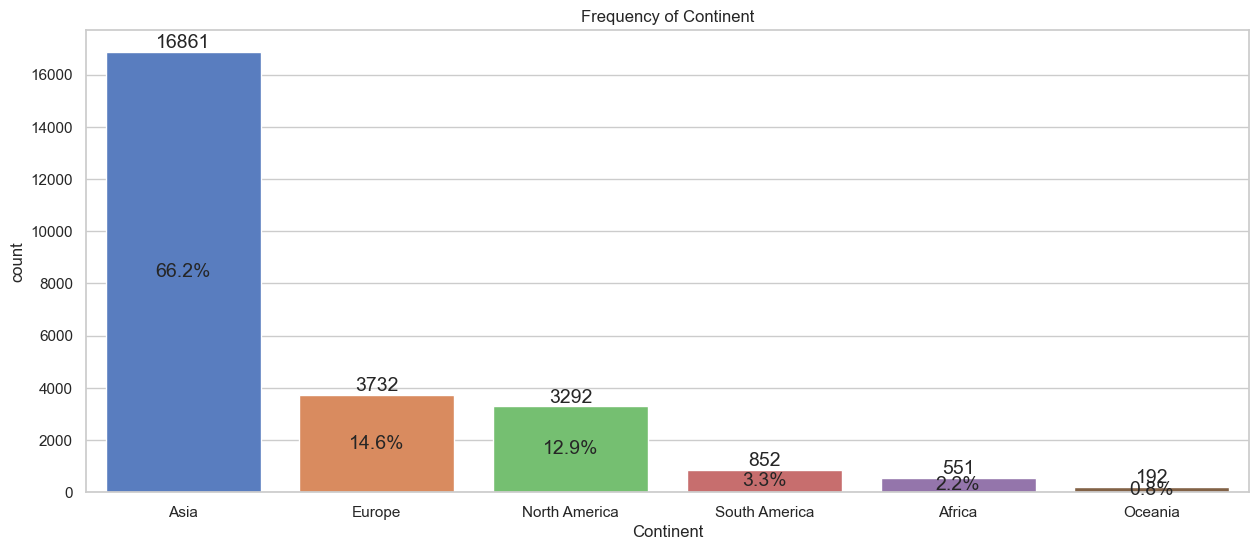

In [21]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'continent', label='Continent')

🔍 Based on the continent distribution shown in your EDA:

1. **Asia dominates applications**: Two-thirds (66.2%) of all visa applications come from Asia, making it by far the largest source of applicants.

2. **Europe and North America follow**: These regions account for 14.6% and 12.9% respectively, forming the second tier of applicants.

3. **Limited representation from other regions**: South America (3.3%), Africa (2.2%), and Oceania (0.8%) contribute relatively few applications.

**For modeling**: The heavy imbalance across continents means tree-based models will have much more data to learn patterns for Asian applicants than for those from smaller regions like Oceania.


#### 2. Education of Employee
(categorical - ordinal)

In [22]:
df['education_of_employee'].describe()

count          25480
unique             4
top       Bachelor's
freq           10234
Name: education_of_employee, dtype: object

In [23]:
df['education_of_employee'].value_counts()

Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64

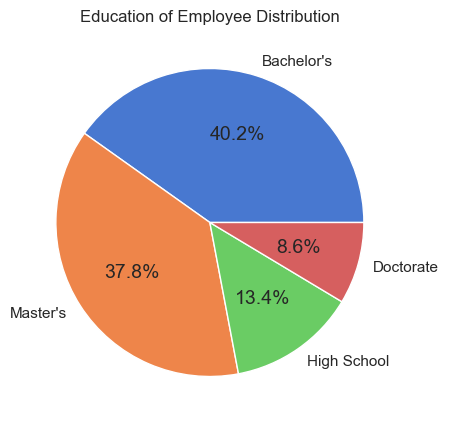

In [24]:
education_counts = df['education_of_employee'].value_counts()
education_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel('')  # Remove y-label
plt.title('Education of Employee Distribution')
plt.show()

🔍 Based on the education distribution:

1. **Bachelor's and Master's degrees dominate**: These two education levels account for nearly 80% of all applicants (40.2% Bachelor's, 37.8% Master's).

2. **Fewer high school and doctorate applicants**: High school graduates (13.4%) and doctorate holders (8.6%) represent smaller portions of the applicant pool.

3. **Highly educated workforce**: The vast majority (86.6%) of visa applicants have college degrees, indicating employers are primarily seeking skilled, educated workers.

> tree-based models will have substantial data across all education categories, though they may learn more reliable patterns for Bachelor's and Master's degree holders.

#### 3. Has Job Experience
(categorical - binary)

In [25]:
df['has_job_experience'].describe()

count     25480
unique        2
top           Y
freq      14802
Name: has_job_experience, dtype: object

In [26]:
df['has_job_experience'].value_counts()

Y    14802
N    10678
Name: has_job_experience, dtype: int64

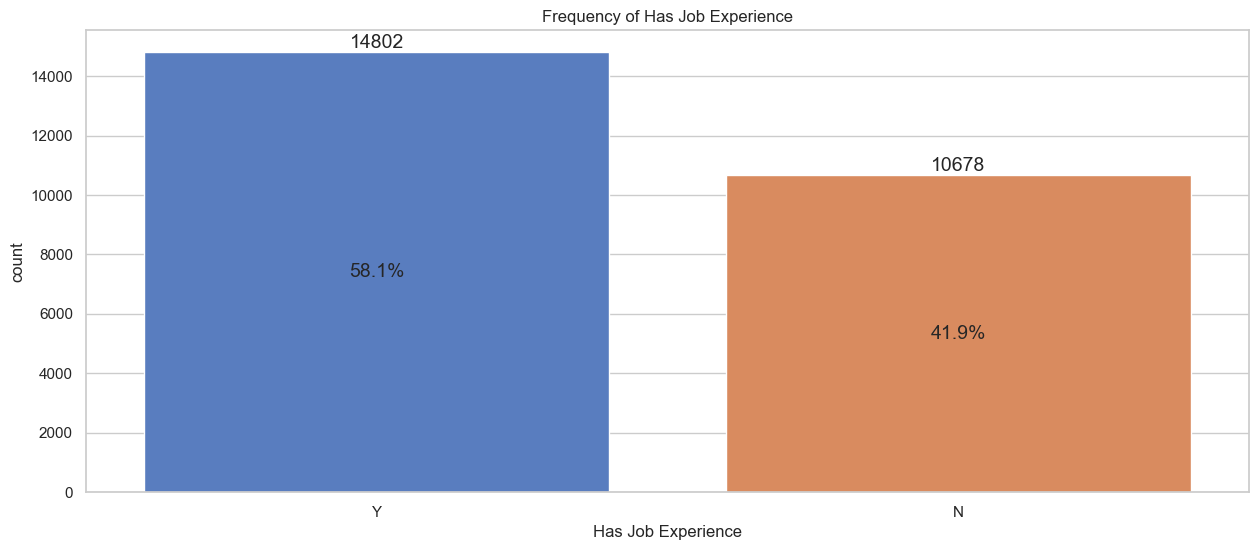

In [27]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'has_job_experience', label='Has Job Experience')

🔍 Based on the job experience distribution:

1. **Experience dominates**: Most applicants (58.1%) have job experience, while a substantial minority (41.9%) do not.

2. **Balanced distribution**: The split between experienced and inexperienced applicants is relatively balanced, with a moderate skew toward experienced workers.

3. **Diverse talent pool**: The significant presence of both experienced and inexperienced applicants suggests visa programs serve both entry-level and experienced positions.

> Your tree-based models will have sufficient data for both experience categories, allowing reliable pattern detection for both groups.

#### 4. Requires Job Training
(categorical - binary)

In [28]:
df['requires_job_training'].describe()

count     25480
unique        2
top           N
freq      22525
Name: requires_job_training, dtype: object

In [29]:
df['requires_job_training'].value_counts()

N    22525
Y     2955
Name: requires_job_training, dtype: int64

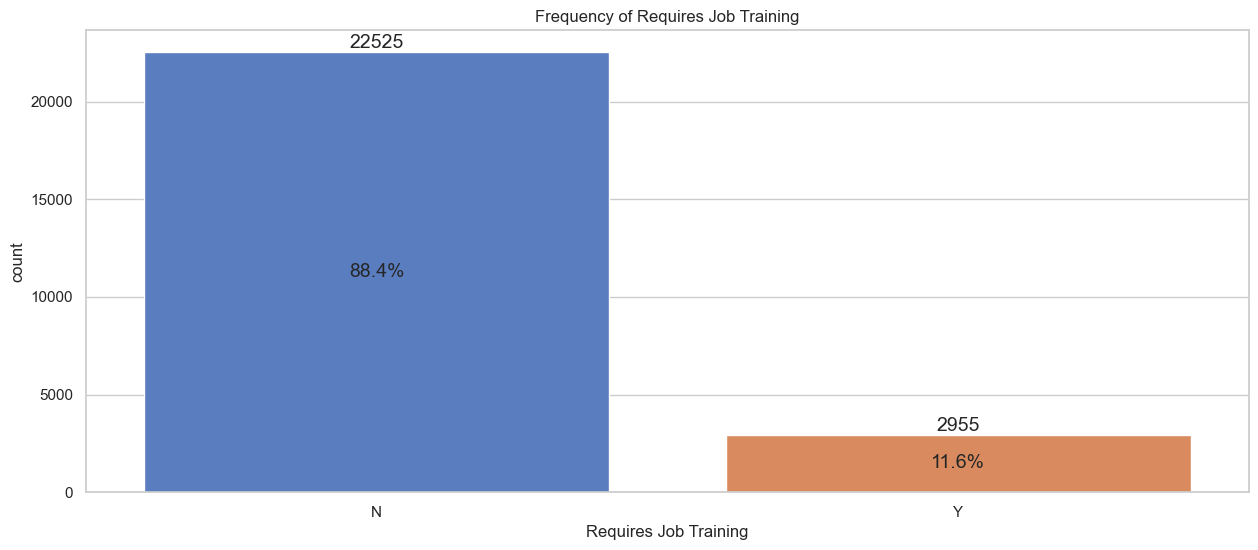

In [30]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'requires_job_training', label='Requires Job Training')


🔍 Observations : 

1. **Training rarely required**: The vast majority of applicants (88.4%) do not require job training, while only a small portion (11.6%) do.

2. **Strong imbalance**: This feature shows a significant imbalance, with "No training required" being the dominant category by a large margin.

3. **Specialized workforce**: The low need for training suggests most visa applicants already possess the necessary skills for their positions.

> The significant imbalance (88.4% vs 11.6%) means the "requires training" category is rare, which could cause tree-based models to treat it as an outlier or underweight its importance unless it has a very strong signal for visa outcomes.

🧠 **REMEMBER (Trees Point)**: 
1. If category dominates then The tree might split based on it too soon
2. If category is too rare then The tree might overfit to noise

> ⚡ **NOTE**: 
> **Tree doesn't directly prefer dominant categories, but dominance can influence impurity reduction calculations, making it more likely to be picked**


#### 5. Number of Employees
(Numerical)

In [31]:
tb_describe(df['no_of_employees'])

                    count     mean       std     min      25%      50%      75%        max
---------------  --------  -------  --------  ------  -------  -------  -------  ---------
no_of_employees  25480.00  5667.04  22877.93  -26.00  1022.00  2109.00  3504.00  602069.00


In [32]:
print('Skewness : ', df['no_of_employees'].skew())
print('Kurtosis : ', df['no_of_employees'].kurt())


Skewness :  12.265260077708275
Kurtosis :  206.33501961590892


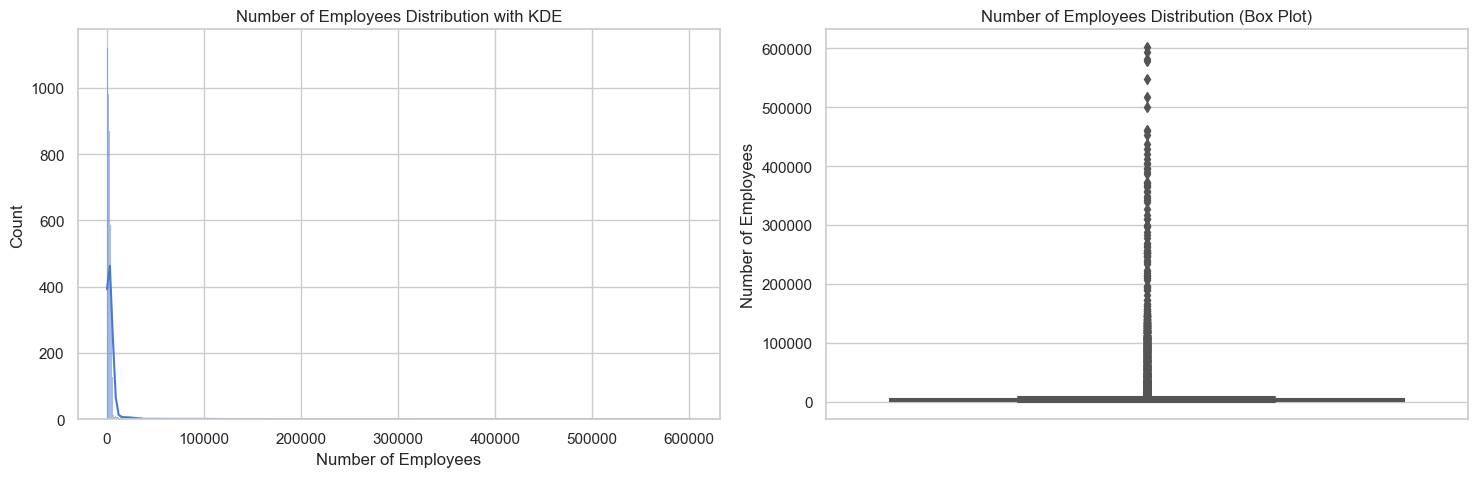

In [34]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='no_of_employees', kde=True, ax=ax1)
ax1.set_title('Number of Employees Distribution with KDE')
ax1.set_xlabel('Number of Employees')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df['no_of_employees'], ax=ax2)
ax2.set_title('Number of Employees Distribution (Box Plot)')
ax2.set_ylabel('Number of Employees')

plt.tight_layout()
plt.show()

🧐 Observations: 

- Region is very dense & narrow at first glance
- From box plot, it's visible that there are many outliers & values are tightly clustered, so which might make Tree struggle.
- If most values fall within a narrow range, the Decision Tree may struggle to find useful splits because there’s low variance in the feature. (ie **Feature might have low predictive power**)


The extreme skewness (12.26) and kurtosis (206.33) indicate the data is heavily concentrated in a narrow range with many outliers, which could cause a tree-based model to create inefficient splits or overfit to rare values. If most values fall within a narrow range, the Decision Tree may struggle to find useful splits because there's low variance in the feature.


> Might need Binning or Log-Transform to visualize it better

Let's Try **Log-Transform**
- to spread out the compressed values
- Smooths right-skewed data

In [35]:
# check if there are any -ve values
df['no_of_employees'].min()

-26

In [49]:
df['no_of_employees'].value_counts().max()

18

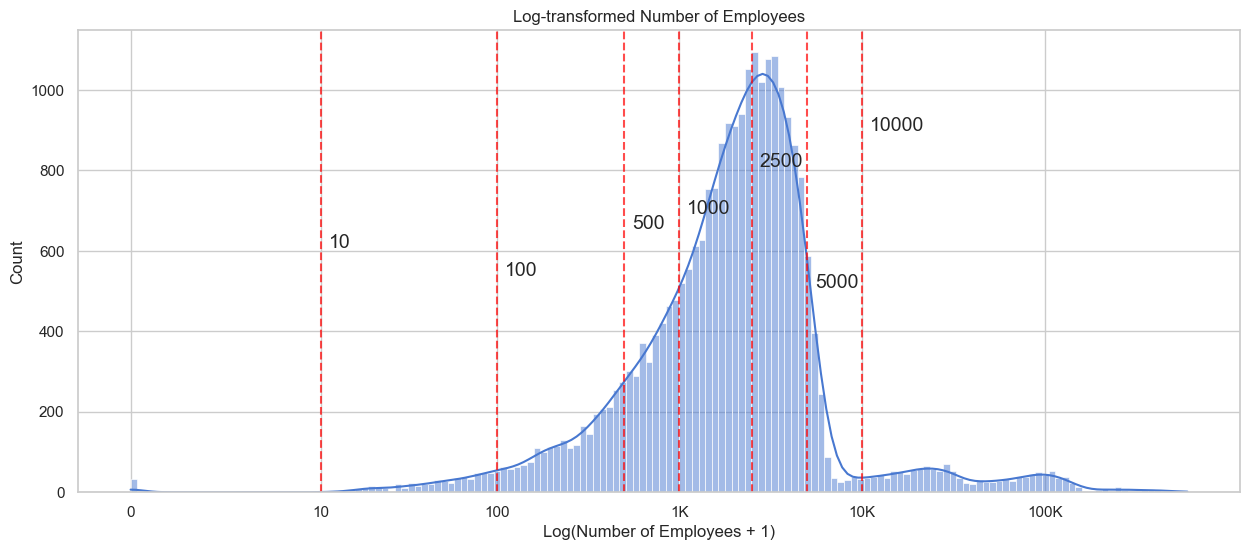

In [58]:
# Log Transformation (Strategy to handle Skewed Data)

plt.figure(figsize=(15, 6))

# Log transformation (adding 1 to handle zeros/negative values)
# NOTE: clip() is used to clip the values to a minimum of 0, as log works only for positive values
log_employees = np.log1p(df['no_of_employees'].clip(lower=0))

# Plot histogram with KDE
sns.histplot(log_employees, kde=True)

# find the reference point for number having highest frequency
df['no_of_employees'].value_counts().idxmax()

# Add reference lines with annotations
reference_points = [10, 100, 500, 1000, 2500, 5000, 10000]
for point in reference_points:
    log_point = np.log1p(point)
    plt.axvline(x=log_point, color='red', linestyle='--', alpha=0.7)
    vertical_offset = np.random.uniform(0.4, 0.9)
    plt.text(log_point + 0.1, plt.ylim()[1]*vertical_offset, f'{point}', verticalalignment='top')

# Customize x-axis ticks to show original values
log_ticks = [np.log1p(x) for x in [0, 10, 100, 1000, 10000, 100000]]
plt.xticks(log_ticks, ['0', '10', '100', '1K', '10K', '100K'])

plt.title('Log-transformed Number of Employees')
plt.xlabel('Log(Number of Employees + 1)')
plt.ylabel('Count')
plt.show()

📌 Points 

- Peaks might represnt potential grouping
- Valleys may suggest natural seperation points

In [55]:
# skewness and kurtosis for log-transformed data
print('Skewness : ', log_employees.skew())
print('Kurtosis : ', log_employees.kurt())

Skewness :  -0.09672037380703381
Kurtosis :  3.7313228285861375


⚡ Based on Log transformed visualization

1. **Bell-shaped distribution after transformation:** The log transformation reveals a nearly normal distribution (skew: -0.09, kurtosis: 3.73), centered between 100-10K employees.
2. **Natural groupings emerge**: several peaks and valleys can be seen, suggesting natural company size categories that could be useful for binning.
3. **Multiple clusters in larger companies**: The right tail shows several smaller peaks, indicating potential sub-groups within large companies (>10K employees).


💡 **Most visa applications come from mid-sized companies (100-10K employees), with fewer applications from very small or very large organizations.**

>🤔 NOTE:
>
> Log transformation is useful for linear models but less necessary for trees

Let's try **Binning**

It Creates meaningful categories that are easy to understand and explain

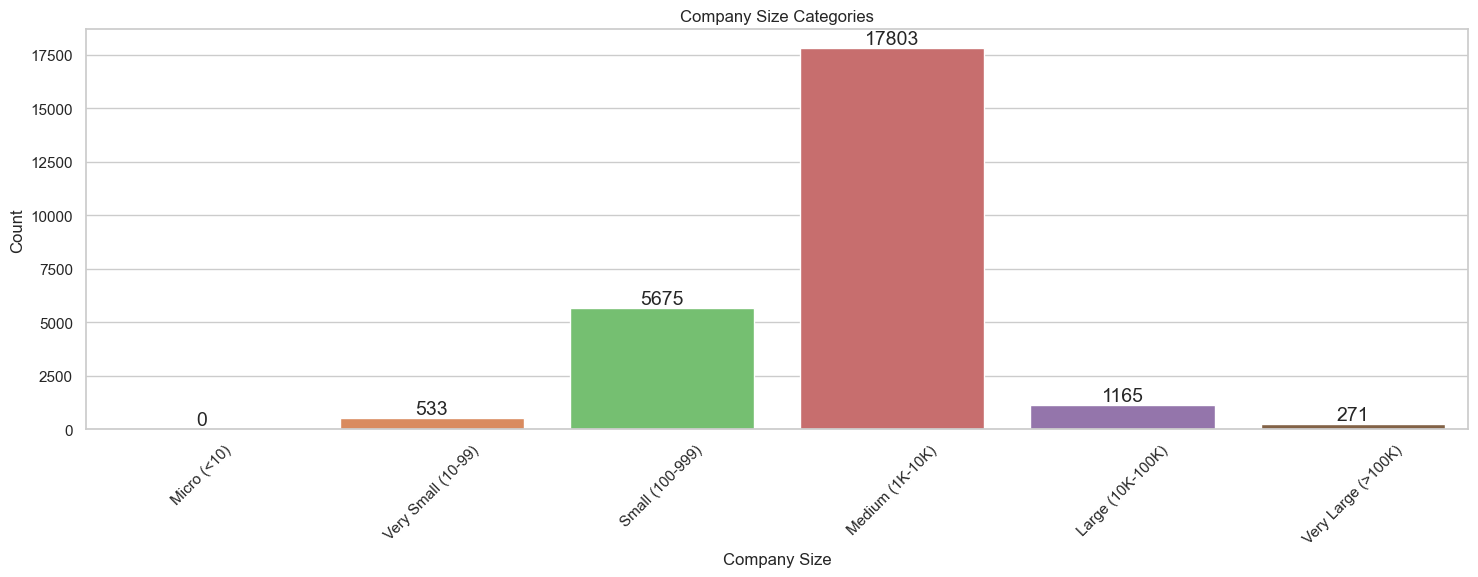

In [63]:
# Binning (Strategy to handle Skewed Data)

# Create company size categories
bins = [0, 10, 100, 1000, 10000, 100000, float("inf")]
labels = [
    "Micro (<10)",
    "Very Small (10-99)",
    "Small (100-999)",
    "Medium (1K-10K)",
    "Large (10K-100K)",
    "Very Large (>100K)",
]

# Create new binned feature
company_size_feature = pd.cut(
    df["no_of_employees"].clip(lower=0), bins=bins, labels=labels
)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=company_size_feature)
plt.title("Company Size Categories")
plt.xlabel("Company Size")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [64]:
company_size_feature.value_counts()

Medium (1K-10K)       17803
Small (100-999)        5675
Large (10K-100K)       1165
Very Small (10-99)      533
Very Large (>100K)      271
Micro (<10)               0
Name: no_of_employees, dtype: int64

In [65]:
company_size_feature.value_counts(normalize=True) * 100

Medium (1K-10K)      69.96
Small (100-999)      22.30
Large (10K-100K)      4.58
Very Small (10-99)    2.09
Very Large (>100K)    1.06
Micro (<10)           0.00
Name: no_of_employees, dtype: float64

In [66]:
pd.crosstab(company_size_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
no_of_employees,,
Very Small (10-99),62.66,37.34
Small (100-999),66.20,33.80
Medium (1K-10K),66.99,33.01
Large (10K-100K),68.07,31.93
Very Large (>100K),70.11,29.89


🔍 Observations : 

1. **Medium-sized companies dominate**: Nearly 70% of visa applications come from medium-sized companies (1K-10K employees), with small companies (100-999) accounting for another 22%.

2. **Very small and very large companies are rare**: Companies with fewer than 100 or more than 10K employees together represent less than 8% of applications.

3. **Approval rates increase with company size**: There's a clear trend where larger companies have higher visa approval rates - from 62.7% for very small companies to 70.1% for very large companies.

🚀 **Business insight**: Larger companies appear more successful at navigating the visa process, possibly due to more resources, experience with immigration procedures, or stronger business cases.

🤔 **Company size** shows a meaningful relationship with the target variable, making it likely to be an important feature in your tree-based models.

> Hence a new column ie CompanySize can be cooked during preprocessing (if possible)


#### 6. Year of Establishment
(numerical)

In [67]:
colname = 'yr_of_estab'

In [70]:
tb_describe(df[colname])

                count     mean    std      min      25%      50%      75%      max
-----------  --------  -------  -----  -------  -------  -------  -------  -------
yr_of_estab  25480.00  1979.41  42.37  1800.00  1976.00  1997.00  2005.00  2016.00


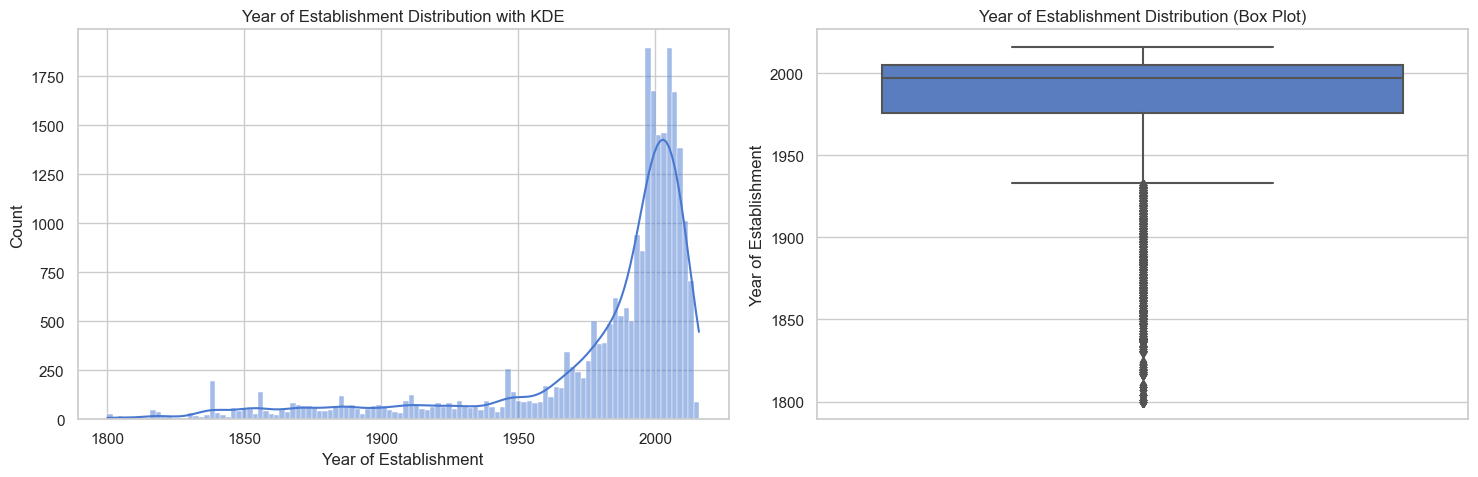

In [68]:
# Histogram and Box Plot
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot 1: Histogram with KDE
sns.histplot(data=df, x=colname, kde=True, ax=ax1)
ax1.set_title('Year of Establishment Distribution with KDE')
ax1.set_xlabel('Year of Establishment')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df[colname], ax=ax2)
ax2.set_title('Year of Establishment Distribution (Box Plot)')
ax2.set_ylabel('Year of Establishment')

plt.tight_layout()
plt.show()

> The distribution is reasonably interpretable

In [69]:
# Skewness and Kurtosis
print('Skewness : ', df[colname].skew())
print('Kurtosis : ', df[colname].kurt())


Skewness :  -2.037301271676438
Kurtosis :  3.506956756052395


🔍 Observations 

1. **Left-skewed distribution**: Most companies are relatively newer.

2. **Outliers on the left**: The box plot shows many outliers on the lower end, representing very old companies established well before the majority.

3. **Business insight**: Most visa applications come from companies established in recent decades, with fewer from very old companies.
   
4. **Bell-shaped region focus**: Most splits will likely occur in the dense 1950-2000 region where most companies fall, potentially finding meaningful thresholds like pre/post-1980.


⚡ Points 

The data shows that as years progress, more companies in the dataset were established, with a concentration of companies founded in recent decades. This reflects both the general growth in business formation over time and possibly a higher likelihood of newer companies seeking foreign workers through visa applications.

🧐 **Potential insight**: The model might discover that very old companies (e.g., established before 1900) have different approval patterns than modern companies.

💡 NOTE: 

1. Trees are invariant to monotonic transformations
2. They handle skewed distributions and outliers naturally
3. They make splits based on rank ordering, not absolute values

**Ensemble advantage**: Ensemble methods like Random Forest will reduce the impact of outlier-based splits through averaging multiple trees.


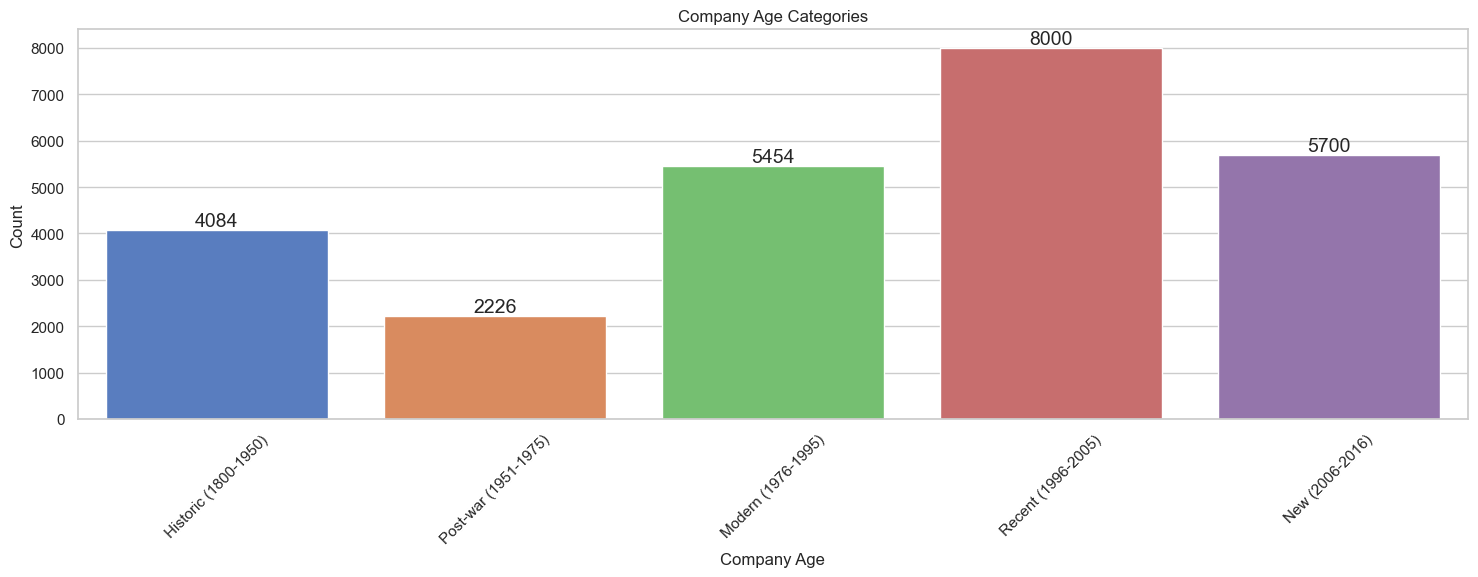

In [72]:
# Binning (Strategy to handle Skewed Data)

# Create company age categories
bins = [1800, 1950, 1975, 1995, 2005, 2016]
labels = ['Historic (1800-1950)', 'Post-war (1951-1975)',
          'Modern (1976-1995)', 'Recent (1996-2005)',
          'New (2006-2016)']

# Create new binned feature
company_age_feature = pd.cut(df['yr_of_estab'],
                                   bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=company_age_feature)
plt.title('Company Age Categories')
plt.xlabel('Company Age')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [74]:
company_age_feature.value_counts()

Recent (1996-2005)      8000
New (2006-2016)         5700
Modern (1976-1995)      5454
Historic (1800-1950)    4084
Post-war (1951-1975)    2226
Name: yr_of_estab, dtype: int64

In [76]:
company_age_feature.value_counts(normalize=True) * 100

Recent (1996-2005)     31.42
New (2006-2016)        22.38
Modern (1976-1995)     21.42
Historic (1800-1950)   16.04
Post-war (1951-1975)    8.74
Name: yr_of_estab, dtype: float64

In [77]:
pd.crosstab(company_age_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
yr_of_estab,,
Historic (1800-1950),66.19,33.81
Post-war (1951-1975),66.62,33.38
Modern (1976-1995),65.44,34.56
Recent (1996-2005),66.04,33.96
New (2006-2016),69.63,30.37


🔍 Observations:

1. **Recent companies dominate**: Companies established between 1996-2005 form the largest group (31.4%), followed by new companies from 2006-2016 (22.4%).

2. **Even distribution across eras**: The remaining companies are fairly evenly distributed across Modern (21.4%) and Historic (16.0%) periods, with fewer from the Post-war era (8.7%).

3. **Newer companies have higher approval rates**: Companies established after 2005 have notably higher approval rates (69.6%) compared to companies from other eras (65-66%).

4. **Consistent denial rates for older companies**: Companies established before 2006 show remarkably consistent denial rates (33-35%), suggesting age isn't a major factor among established companies.

💡 **Business insight**: The data suggests newer companies might have advantages in the visa process, possibly due to being in growing industries or having more modern business practices.

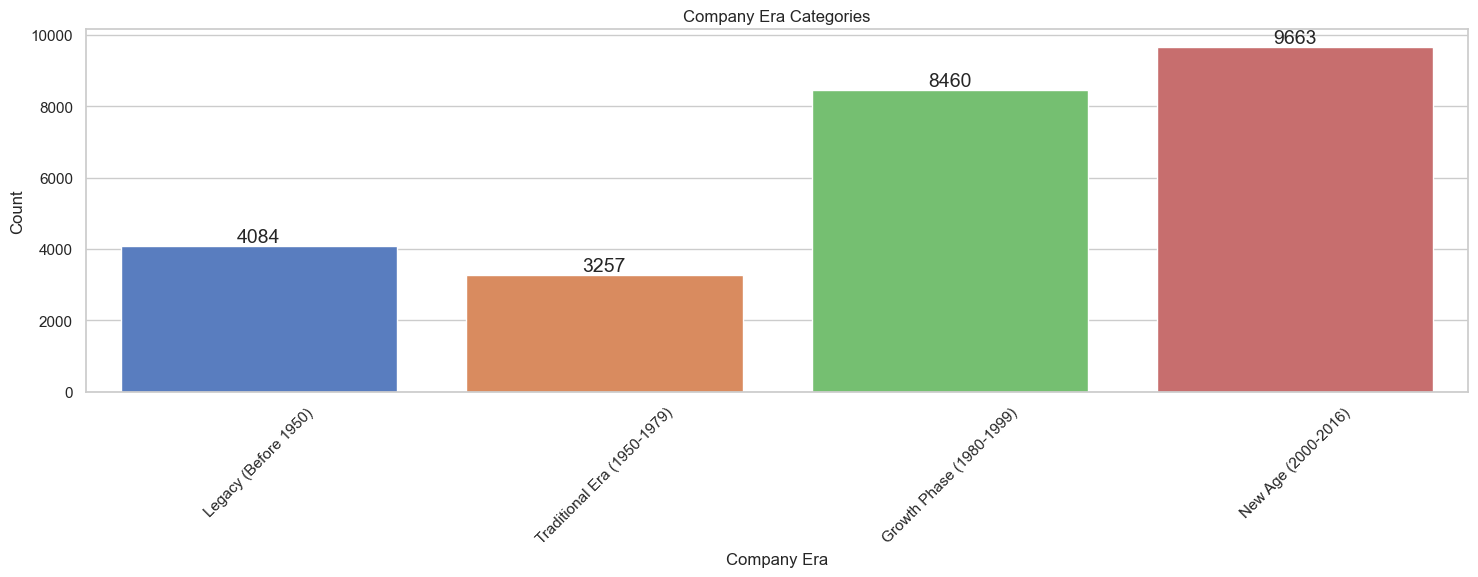

In [73]:
# Binning (Strategy to handle Skewed Data)

# Create company age categories
bins = [1800, 1950, 1980, 2000, 2016]
labels = [
    "Legacy (Before 1950)",
    "Traditional Era (1950-1979)",
    "Growth Phase (1980-1999)",
    "New Age (2000-2016)",
]

# Create new binned feature
company_era_feature = pd.cut(df["yr_of_estab"], bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=company_era_feature)
plt.title("Company Era Categories")
plt.xlabel("Company Era")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [75]:
company_era_feature.value_counts()

New Age (2000-2016)            9663
Growth Phase (1980-1999)       8460
Legacy (Before 1950)           4084
Traditional Era (1950-1979)    3257
Name: yr_of_estab, dtype: int64

In [78]:
company_era_feature.value_counts(normalize=True) * 100

New Age (2000-2016)           37.95
Growth Phase (1980-1999)      33.22
Legacy (Before 1950)          16.04
Traditional Era (1950-1979)   12.79
Name: yr_of_estab, dtype: float64

In [79]:
pd.crosstab(company_era_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
yr_of_estab,,
Legacy (Before 1950),66.19,33.81
Traditional Era (1950-1979),66.50,33.50
Growth Phase (1980-1999),65.51,34.49
New Age (2000-2016),68.26,31.74


🔍 Points

Both analyses reveal similar patterns

1. Modern companies dominate
2. New Age companies have highest approval rates
3. Little difference in visa outcomes among established companies

#### 7 Region of Employment
(Categorical - Nominal)

In [80]:
coname = 'region_of_employment'

In [81]:
df[coname].describe()

count         25480
unique            5
top       Northeast
freq           7195
Name: region_of_employment, dtype: object

In [82]:
df[coname].value_counts()

Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: region_of_employment, dtype: int64

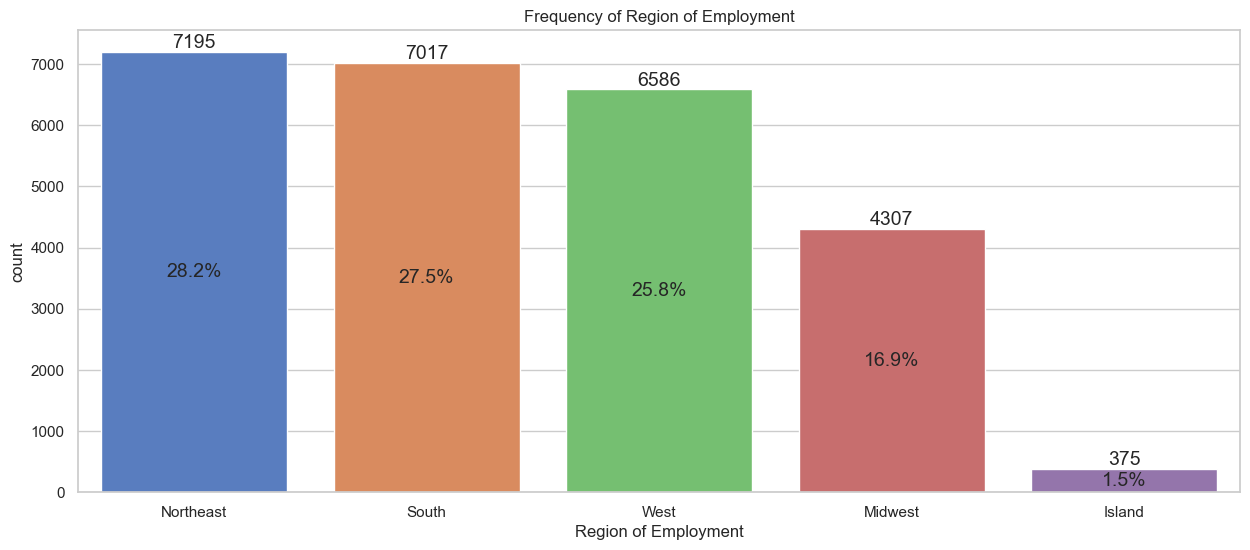

In [84]:
plt.figure(figsize=(15, 6))
draw_countplot(df, coname, label='Region of Employment')

🔍 Observations: 

1. **Balanced distribution across major regions**: Northeast (28.2%), South (27.5%), and West (25.8%) have similar representation, with Midwest slightly lower (16.9%).

2. **Island region is rare**: The Island region represents only 1.5% of applications, making it a minority class.

3. **Coastal dominance**: Coastal regions (Northeast and West) together account for over half of all visa applications, reflecting the concentration of industries that typically hire foreign workers.

4. **Business implications**: Visa processing resources might need to be allocated proportionally across regions, with special consideration for the unique needs of the Island region.

💡 **For modeling**: The significant imbalance with the Island region means tree-based models might have less reliable patterns for this region unless they show very distinct approval patterns.


#### 8. Prevailing Wage (Wage Paid Similalry)
(Numerical)

>  wage paid to similarly employed workers in the same occupation and area

In [85]:
colname = 'prevailing_wage'

In [86]:
tb_describe(df[colname])

                    count      mean       std    min       25%       50%        75%        max
---------------  --------  --------  --------  -----  --------  --------  ---------  ---------
prevailing_wage  25480.00  74455.81  52815.94   2.14  34015.48  70308.21  107735.51  319210.27


In [87]:
# Skewness and Kurtosis
print('Skewness : ', df[colname].skew())
print('Kurtosis : ', df[colname].kurt())


Skewness :  0.7557760603032042
Kurtosis :  0.824273521052552


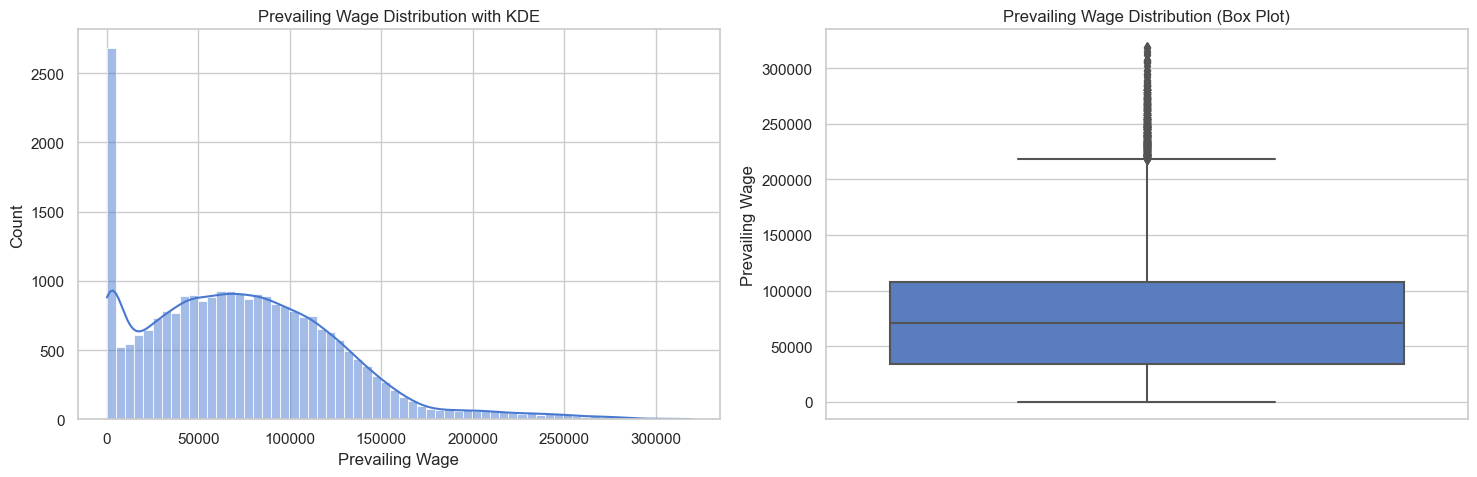

In [88]:
# Histogram and Box Plot
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(data=df, x=colname, kde=True, ax=ax1)
ax1.set_title('Prevailing Wage Distribution with KDE')
ax1.set_xlabel('Prevailing Wage')
ax1.set_ylabel('Count')

sns.boxplot(y=df[colname], ax=ax2)
ax2.set_title('Prevailing Wage Distribution (Box Plot)')
ax2.set_ylabel('Prevailing Wage')
plt.tight_layout()
plt.show()

⚡ Points

1. The distribution is already reasonably bell-shaped & at first glance appears like SNAIL with long TAIL
2. Right skewed but not extreme (many outliers on end)
3. There are few valleys, one on left (neck) and one on right (tail)

🔍 Observations: 

1. **Natural wage thresholds**: The valleys represent transition points between different salary tiers in the labor market.

2. **Distinct job categories**: Each peak likely represents a different job category or skill level - entry-level positions (left peak), professional roles (middle peak), and specialized/executive positions (right peak).

3. **Potential splitting points**: These valleys are natural points where a decision tree might create splits, as they represent meaningful transitions in the wage structure.

4. **Market segmentation**: The labor market naturally segments into these wage bands, reflecting different qualification levels and job responsibilities.

💡 These natural breaks in the distribution could be valuable for creating wage categories that align with real-world job market structures.


In [89]:
df[colname].describe()


count    25480.00
mean     74455.81
std      52815.94
min          2.14
25%      34015.48
50%      70308.21
75%     107735.51
max     319210.27
Name: prevailing_wage, dtype: float64

Let's try **Binning**

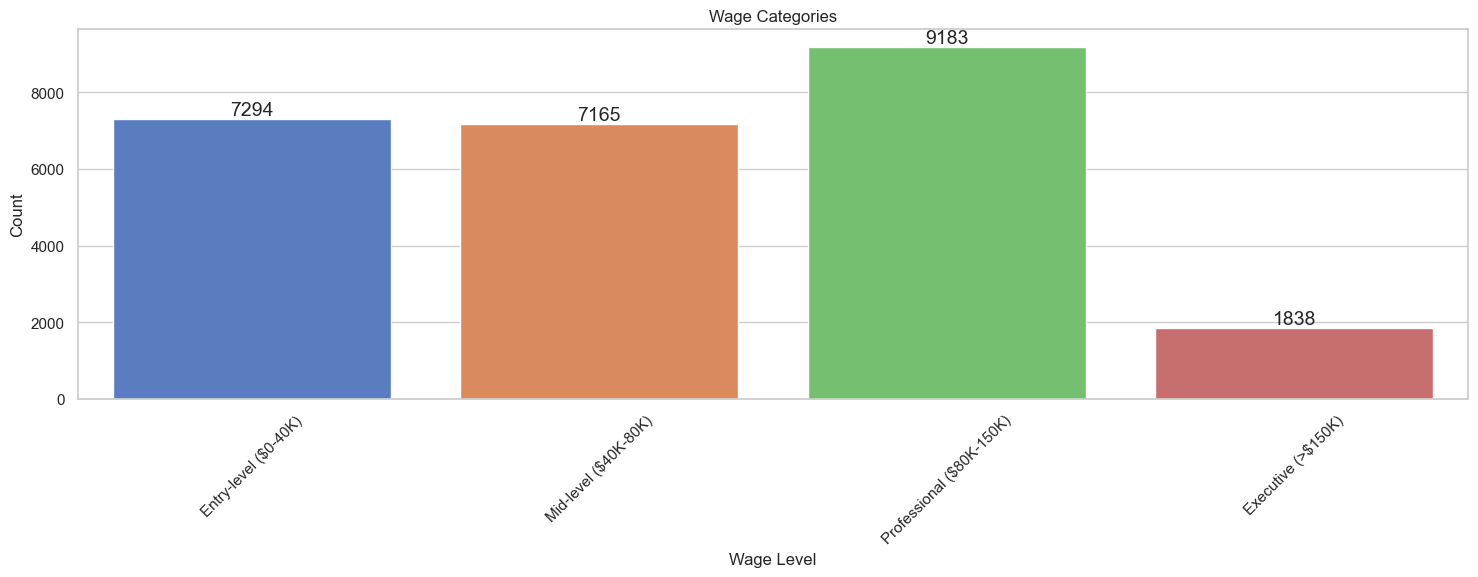

In [90]:
# Binning (Just to explore if it can be useful)

# Create wage categories based on observed distribution patterns
bins = [0, 40000, 80000, 150000, 320000]
labels = ['Entry-level ($0-40K)', 'Mid-level ($40K-80K)',
          'Professional ($80K-150K)', 'Executive (>$150K)']

# Create new binned feature
wage_category_feature = pd.cut(df['prevailing_wage'],
                            bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=wage_category_feature)
plt.title('Wage Categories')
plt.xlabel('Wage Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [91]:
wage_category_feature.value_counts()

Professional ($80K-150K)    9183
Entry-level ($0-40K)        7294
Mid-level ($40K-80K)        7165
Executive (>$150K)          1838
Name: prevailing_wage, dtype: int64

In [92]:
wage_category_feature.value_counts(normalize=True) * 100

Professional ($80K-150K)   36.04
Entry-level ($0-40K)       28.63
Mid-level ($40K-80K)       28.12
Executive (>$150K)          7.21
Name: prevailing_wage, dtype: float64

In [93]:
pd.crosstab(wage_category_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
prevailing_wage,,
Entry-level ($0-40K),60.82,39.18
Mid-level ($40K-80K),69.38,30.62
Professional ($80K-150K),68.86,31.14
Executive (>$150K),70.08,29.92


🔍 Observation: 

1. **Professional wages dominate**: The largest group is Professional ($80K-150K) at 36%, with Entry-level and Mid-level each representing about 28% of applications.

2. **Executive wages are rare**: Only 7.2% of applications are for Executive-level wages (>$150K).

3. **Clear relationship with visa outcomes**: Entry-level wages have significantly lower approval rates (60.8%) compared to all other categories (69-70%).

4. **Higher wages, higher approvals**: There's a positive relationship between wage level and approval rate, with Executive wages having the highest approval rate (70.1%).

⚡ **Business insight**: The substantial gap in approval rates between Entry-level and other categories suggests wage is an important factor in visa decisions, with applications for lower-paid positions facing greater scrutiny.

> This strong relationship makes wage category likely to be an important feature in your tree-based models.


#### 9. Unit of Wage
(Category)

In [94]:
colname = 'unit_of_wage'

In [95]:
df[colname].describe()

count     25480
unique        4
top        Year
freq      22962
Name: unit_of_wage, dtype: object

In [96]:
df[colname].value_counts()

Year     22962
Hour      2157
Week       272
Month       89
Name: unit_of_wage, dtype: int64

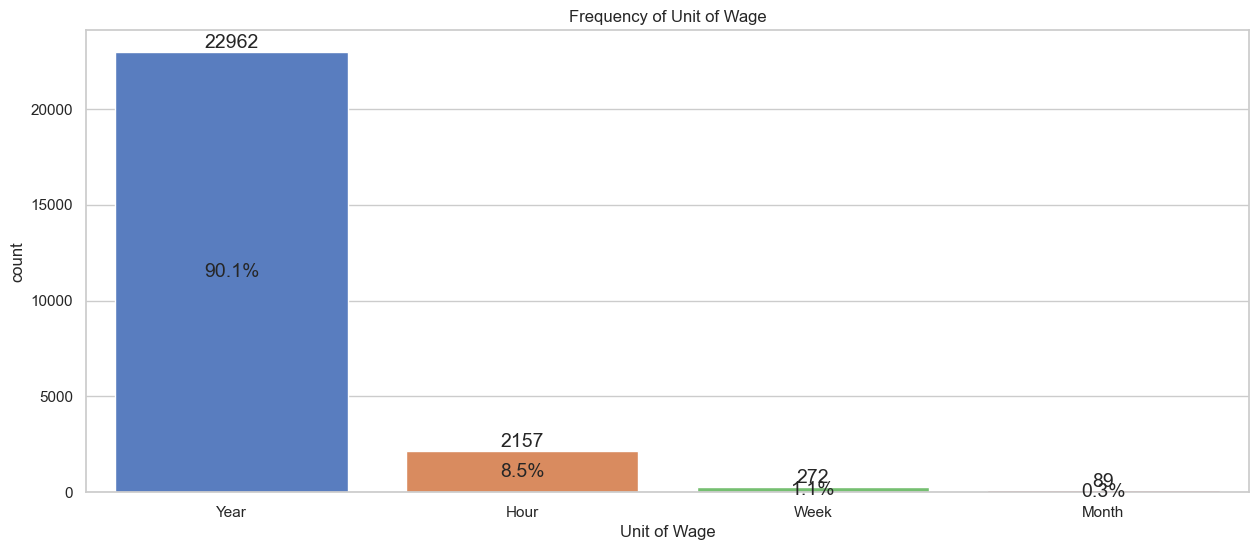

In [100]:
plt.figure(figsize=(15, 6))
draw_countplot(df, colname, label='Unit of Wage')

🔍 Observations:

1. **Yearly wages dominate**: The vast majority (90.1%) of applications report wages on a yearly basis.

2. **Hourly wages are distant second**: Only 8.5% of applications use hourly wage rates.

3. **Weekly and monthly are rare**: These units combined represent just 1.4% of applications.

4. **Extreme imbalance**: The distribution is highly skewed toward yearly wages, creating a significant class imbalance & a dominant category as "Yearly Wage"

💡 **Business insight**: Most visa applications are for salaried positions rather than hourly wage jobs, reflecting the professional nature of many visa-sponsored positions.

❗ **For modeling**: The extreme imbalance means tree-based models will have limited data to learn patterns for the minority classes (especially weekly and monthly wages), potentially making predictions less reliable for these groups.


#### 10. Full Time Position
(Categorical - Binary)

In [101]:
colname = 'full_time_position'

In [102]:
df[colname].describe()

count     25480
unique        2
top           Y
freq      22773
Name: full_time_position, dtype: object

In [103]:
df[colname].value_counts()

Y    22773
N     2707
Name: full_time_position, dtype: int64

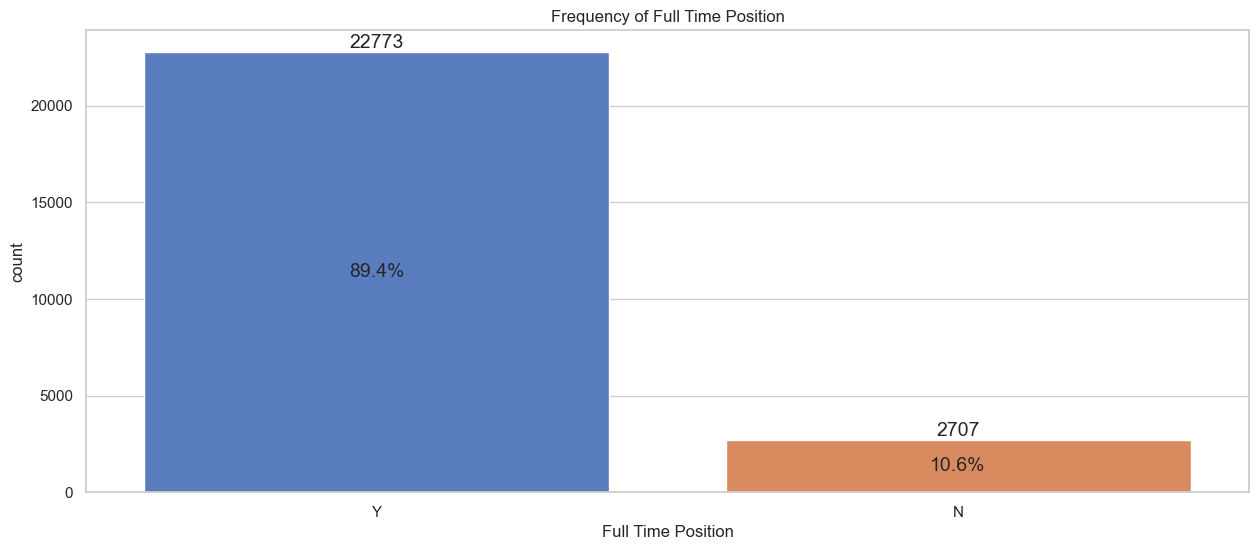

In [104]:
plt.figure(figsize=(15, 6))
draw_countplot(df, colname, label='Full Time Position')

🔍 Observations: 

1. **Full-time positions dominate**: The vast majority (89.4%) of visa applications are for full-time positions.

2. **Part-time positions are rare**: Only 10.6% of applications are for part-time positions.

3. **Strong imbalance**: The distribution is heavily skewed toward full-time positions.

🚀 **Business insight**: Visa programs are primarily used for full-time employment, reflecting immigration policies that generally favor permanent, stable positions over temporary or part-time work.

⚡ **For modeling**: The significant imbalance means tree-based models will have less data to learn patterns for part-time positions, potentially making predictions less reliable for this minority class unless it shows very distinct approval patterns.

> rarity can make it an informative split if it strongly correlates with the target.
> 
> If rarity correlates good with target then it may reveals risk of overfitting

#### 11. Case Status
(Target - Binary)

In [105]:
colname = 'case_status'

In [106]:
df[colname].describe()

count         25480
unique            2
top       Certified
freq          17018
Name: case_status, dtype: object

In [107]:
df[colname].value_counts()

Certified    17018
Denied        8462
Name: case_status, dtype: int64

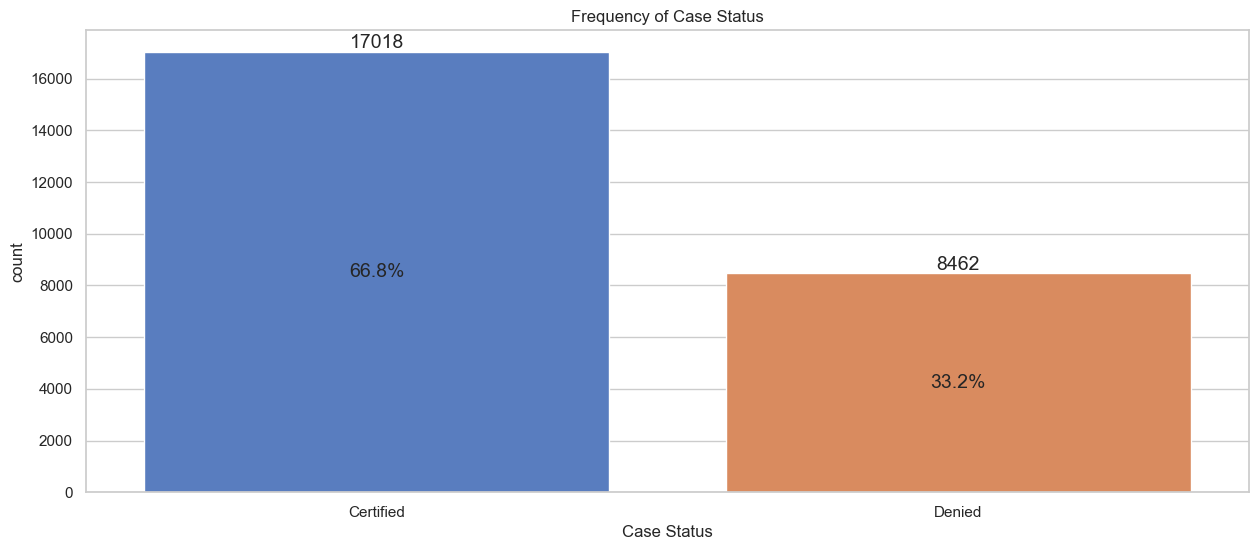

In [108]:
plt.figure(figsize=(15, 6))
draw_countplot(df, colname, label='Case Status')

🧐 Observations:

1. **Approval dominates**: About two-thirds (66.8%) of visa applications are certified (approved).

2. **One-third denied**: The remaining one-third (33.2%) of applications are denied.

3. **Moderate imbalance**: While there is class imbalance, it's not extreme - both classes have substantial representation.

4. **Business context**: The approval rate aligns with the purpose of the visa program, which is designed to approve qualified applications while maintaining standards.

🚀 **For modeling**: 
   - The moderate imbalance means standard classification metrics may be appropriate
   - Focus on both precision and recall, especially for the "Denied" class
   - The dataset has sufficient examples of both outcomes for effective learning

🎯 **Evaluation strategy**: Given the business context, Prioritize correctly identifying applications that should be denied (recall for the "Denied" class) is at crux.
- ensures we correctly identify actual denials, reducing "false negatives".
- If wrongly predicted as Certified, it could lead to misinformed decisions in real-world applications.

👀 **Regulatory perspective**: The visa program's purpose is to protect US workers while allowing qualified foreign workers. Missing a case that should be denied (false negative) could undermine this protection.

⚡ **Cost of errors**: 
- **False positive** (predicting Certified when actually Denied): Could allow unqualified applicants through, potentially affecting US labor market
- **False negative** (predicting Denied when actually Certified): Delays a qualified applicant, but they can appeal or reapply


---

## MultiVariate Analysis

#### Helper (Python)

In [128]:
def create_stacked_bar(
    df,
    feature,
    title="Approval Rates by Feature",
    xlabel="Feature",
    ylabel="Percentage",
    colors=["steelblue", "lightcoral"],
):
    """
    Create a stacked bar chart showing the distribution of a binary target variable
    across categories of a feature.

    returns crosstab
    """
    target="case_status"

    # Create a cross-tabulation
    crosstab = pd.crosstab(df[feature], df[target], normalize="index") * 100

    # Create stacked bar chart
    plt.figure(figsize=(12, 8))
    crosstab.plot(kind="bar", stacked=True, color=colors, figsize=(12, 8))

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title=target)

    # Add percentage labels on bars - simplified for binary target
    for i, category in enumerate(crosstab.index):
        # Get percentages
        first_value = crosstab.iloc[i, 0]  # First class (e.g., Certified)
        second_value = crosstab.iloc[i, 1]  # Second class (e.g., Denied)

        # Add text for first class (middle of its section)
        plt.text(
            i,
            first_value / 2,
            f"{first_value:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

        # Add text for second class (middle of its section)
        plt.text(
            i,
            first_value + second_value / 2,
            f"{second_value:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()

    return crosstab


In [132]:
def create_mosaic_plot(df, feature, title=None):
    """
    Create a mosaic plot showing relationship between a feature and target variable


    """
    target='case_status'
    # Create figure
    plt.figure(figsize=(12, 8))

    # Set default title if none provided
    if title is None:
        title = f'{feature} vs {target}'

    # Create the data dictionary for mosaic
    # This creates a dictionary with keys as tuples of (continent, case_status)
    mosaic_data = {(i, j): 0 for i in df[feature].unique() for j in df[target].unique()}
    for i, row in df.iterrows():
        mosaic_data[(row[feature], row[target])] += 1

    # Create mosaic plot
    mosaic(mosaic_data, gap=0.01, title=title,
        properties=lambda key: {'color': 'steelblue' if key[1] == 'Certified' else 'lightcoral'})

    plt.tight_layout()
    plt.show()

#### 1. Continent vs Case Status

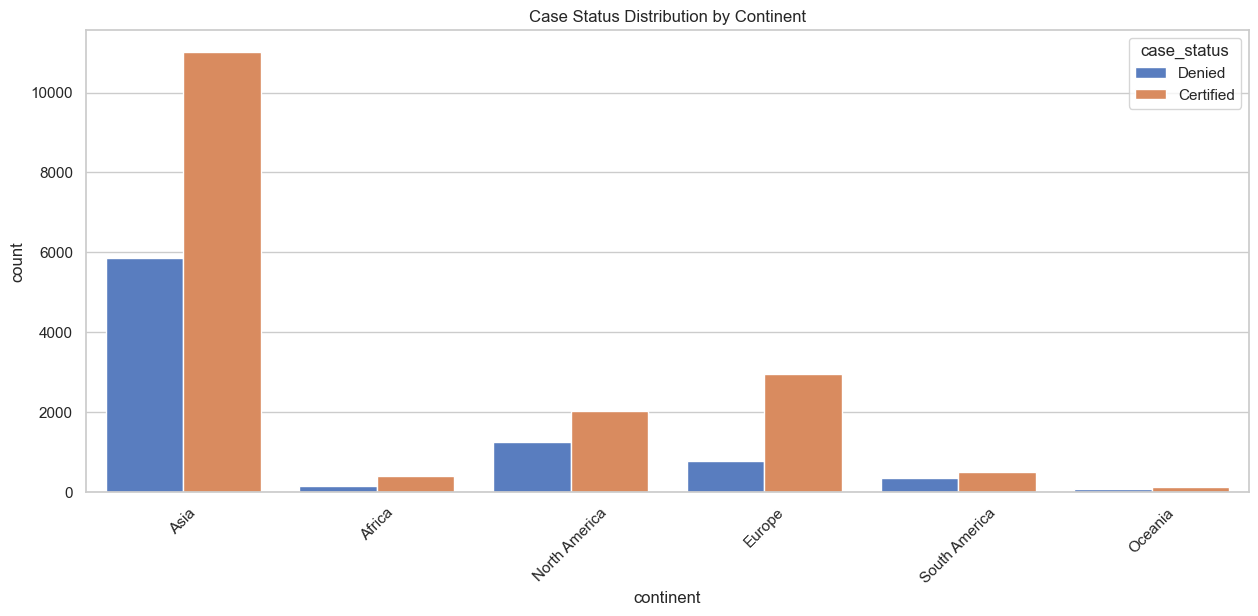

In [114]:
# Grouped Bar Plot
sns.countplot(data=df, x='continent', hue='case_status')
plt.title('Case Status Distribution by Continent')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

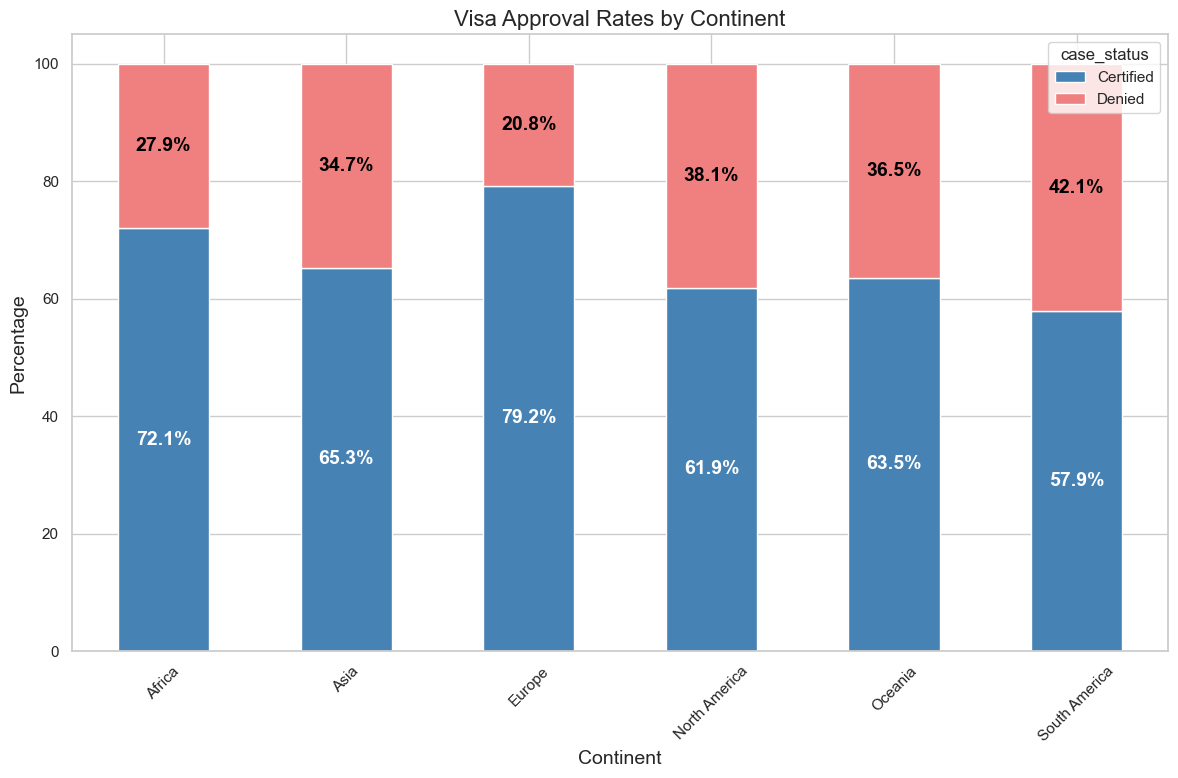

In [129]:
ct = create_stacked_bar(df, 'continent', 'Visa Approval Rates by Continent', 'Continent', 'Percentage')

👀 Points

1. Africa and Europe has good split dominance (ie Imbalance) which Favors Tree based Algorithms.
2. The substantial variation in approval rates (over 21 percentage points between Europe and South America) suggests geographic origin is a meaningful factor in visa outcomes.

Observations

1. **Europe has highest approval rate**: European applicants have a significantly higher approval rate (79.2%) than applicants from other continents, nearly 12 percentage points above the overall average.

2. **South America faces most challenges**: South American applicants have the lowest approval rate (57.9%), facing denials in over 42% of cases.

3. **North America surprisingly low**: Despite proximity, North American applicants have the second-lowest approval rate (61.9%), well below the overall average.

4. **Asia dominates volume but average success**: While Asia represents the majority of applications, its approval rate (65.3%) is slightly below the overall average.

5. **Clear geographic patterns**: The substantial variation in approval rates (over 21 percentage points between Europe and South America) suggests geographic origin is a meaningful factor in visa outcomes.

#### 2. Has Job Experience vs Case Status

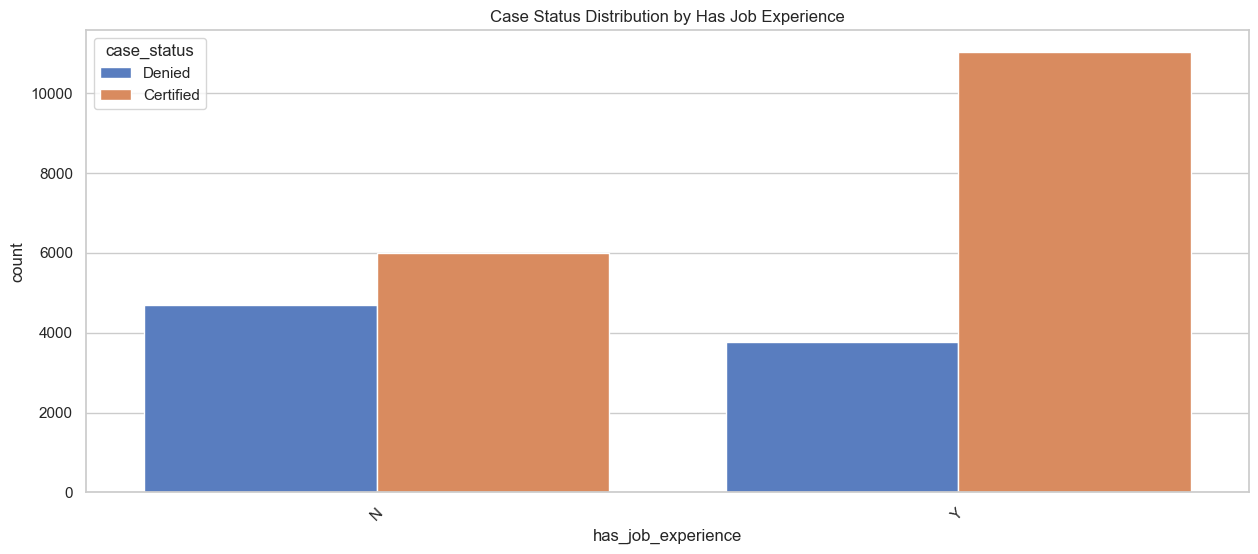

In [131]:
# Grouped Bar Plot
sns.countplot(data=df, x='has_job_experience', hue='case_status')
plt.title('Case Status Distribution by Has Job Experience')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

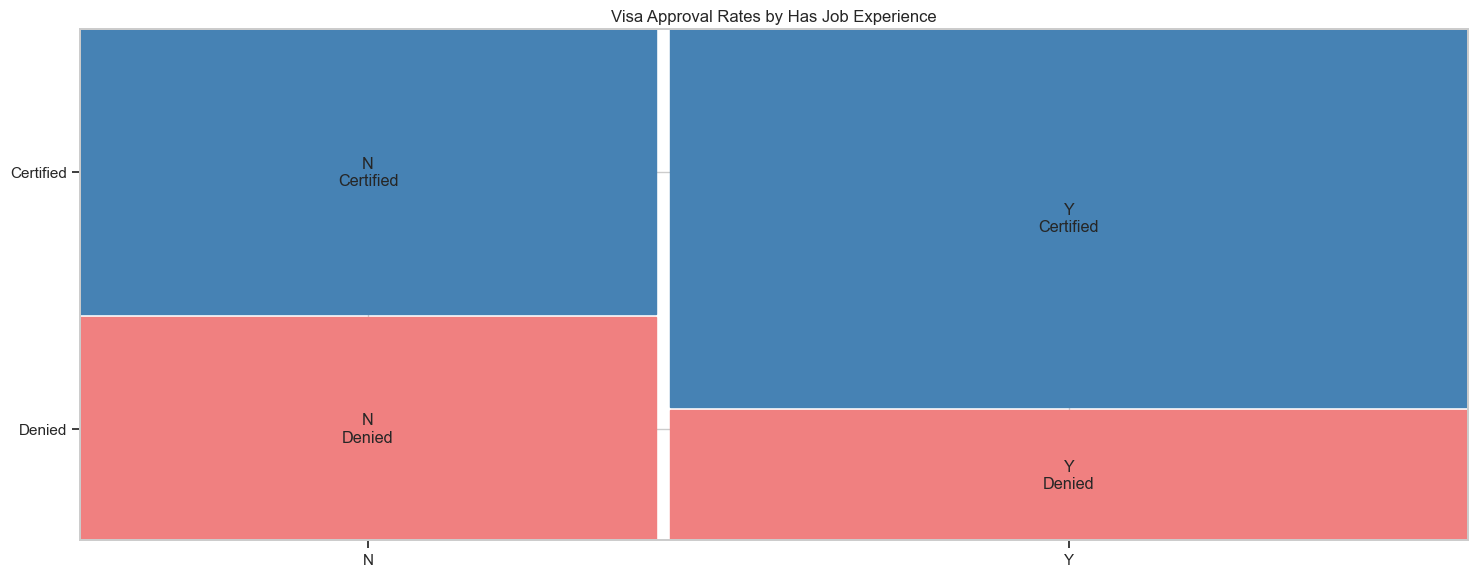

In [133]:
create_mosaic_plot(df, 'has_job_experience', title='Visa Approval Rates by Has Job Experience')

<Figure size 1200x800 with 0 Axes>

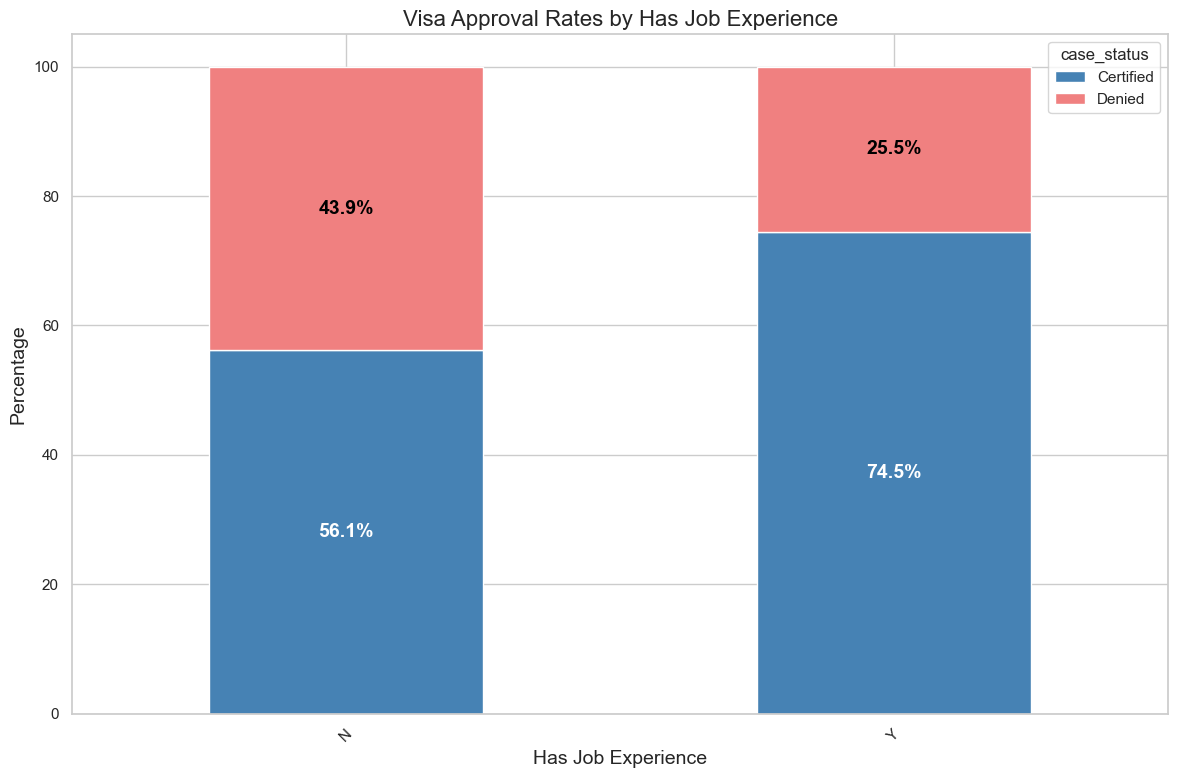

In [134]:
ct = create_stacked_bar(df, 'has_job_experience', 'Visa Approval Rates by Has Job Experience', 'Has Job Experience', 'Percentage')

👀 From above 3 plots:

- We can say that `has_job_experience` does quite good job for `Yes`, because it's
  - Dominating Category
  - Dominating Split too (ie Imbalanced Target Variable in Split Distribution)
- This shows having job experience increases the likelihood of certification

💡 Job experience is a strong influencing factor. Candidates without experience face a higher rejection rate, while those with experience have a much better chance of getting certified. 🚀

🔍 Observations: 

1. **Experience strongly impacts approval**

2. **Inexperienced applicants face high denial rate**: Nearly 44% of applicants without job experience are denied, making this a high-risk category.

3. **Clear decision signal**: The strong relationship suggests experience is likely a key decision factor in the visa approval process.

💡 **Business insight**: This aligns with immigration policies that typically favor experienced workers who can immediately contribute to the workforce.

⚡ **Modeling**: This substantial difference makes job experience likely to be a high-importance feature in your tree-based models, potentially appearing near the top of decision trees.

---

## NOTES - Tree Models

🧠 **Remember**

- Trees naturally handle outliers by creating separate branches.
- They are less sensitive to distribution shape
- Can naturally adapt to skewed distributions
- Create splits that capture data patterns regardless of Symmetry

If the rare class correlates too strongly with the target, it **could** lead to overfitting, especially in small datasets.  

However, in **large datasets and ensemble methods**, trees tend to generalize well because:  
1. **Bootstrap sampling (in Random Forest)** reduces reliance on any single split.  
2. **Regularization (in Gradient Boosting)** helps control overfitting.  
3. **Tree depth limits** prevent overly specific patterns from dominating.  

So, while rarity **can** be a red flag, it’s not always a problem if handled correctly.

📌 **Log Transformation & Tree based Model:**

🌳 **How Decision Trees Work**  
- Trees split data at specific thresholds (e.g., **no_of_employees > 5000**).  
- Log transformation **won’t change the relative order** of values—so splits remain the same.  
- However, **the depth & interpretability might change** because transformed values are harder to relate to the original scale.  

✅ **Bottom Line**  
- **Not needed for trees** (they handle skew naturally).  
- **Useful for linear models** (like Logistic Regression).  
- **Won’t hurt trees significantly**, but may make splits harder to interpret.  

